In [1]:
import tensorflow as tf
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Rescaling #InputLayer, HiddenLayer, OutputLayer
from tensorflow.keras.models import Sequential #Feed-Forward-NN
import matplotlib.pyplot as plt #Plot Images
import os #Access files and folders
import numpy as np #Calculations

2023-05-02 11:23:38.920345: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("GPUs detected: ", len(physical_devices))
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True) #Use GPU if available

GPUs detected:  0


In [2]:
path = "G:/Python/data/10_animals" #Path to dataset
height = width = 300 #Rescale images in dataset to set size
batch_size = 64 #determine batch size for training

train = tf.keras.preprocessing.image_dataset_from_directory( #Loading training-data
    path,
    image_size=(height, width),
    validation_split=0.2, #Determine how many images will be used for validation
    subset="training",
    seed=123, #Shuffling and Transformation
    batch_size=batch_size
)

val = tf.keras.preprocessing.image_dataset_from_directory( #Loading validation-data
    path,
    image_size=(height, width),
    validation_split=0.2,
    subset="training",
    seed=123,
    batch_size=batch_size
)

classes = train.class_names

Found 32086 files belonging to 10 classes.
Using 25669 files for training.
Found 32086 files belonging to 10 classes.
Using 25669 files for training.


In [3]:
print(classes)

['cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel', 'turtle']


In [6]:
#Data-Augmentation
data_aug = Sequential([ 
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255), #Rescale pixel-values to be inbetween 0 and 1
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"), #Randomly flips images
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.3), #Randomly rotates images
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.05, -0.15), width_factor=(-0.05, -0.15)) #Randomly zooms 
])

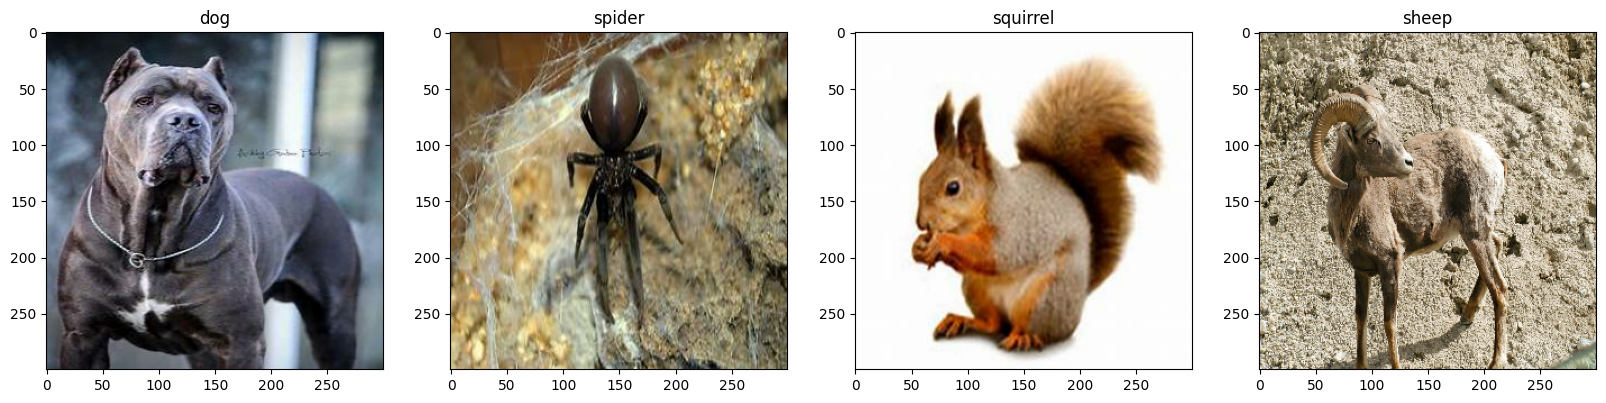

In [6]:
#Plot random images from dataset
data_iterator = train.as_numpy_iterator() 
batch = data_iterator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(classes[batch[1][idx]])

In [8]:
model = Sequential([
    InputLayer((300, 300, 3)), #InputLayer
    data_aug, #DataAugmentation

    Conv2D(32, (3,3), padding='same', activation='relu'), #ConvolutionLayer
    MaxPooling2D(), #PoolingLayer
    Dropout(0.25), #DropoutLayer

    Conv2D(64, (3,3), padding='same', activation='relu'), #ConvolutionLayer
    MaxPooling2D(), #PoolingLayer
    Dropout(0.25), #DropoutLayer

    Conv2D(128, (3,3), padding='same', activation='relu'), #ConvolutionLayer
    MaxPooling2D(), #PoolingLayer
    Dropout(0.25), #DropoutLayer

    Conv2D(128, (3,3), padding='same', activation='relu'), #ConvolutionLayer
    Conv2D(128, (3,3), padding='same', activation='relu'), #ConvolutionLayer

    Conv2D(64, (3,3), padding='same', activation='relu'), #ConvolutionLayer
    MaxPooling2D(), #PoolingLayer
    Dropout(0.25), #DropoutLayer

    Flatten(), #FlattenLayer transforms input into 1-dimensional Array to be processed by Dense Layers
    Dense(256, activation='relu'), #FullyConnectedLayer
    Dense(128, activation='relu'), #FullyConnectedLayer
    Dense(len(classes), activation='softmax') #OutputLayer
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'] #tracking for accuracy
)

model.summary() #overview of built model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 300, 300, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 150, 150, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 64)       0         
 2D)                                                  

In [11]:
model.fit(train, validation_data=val, epochs=35) #Training the model

Epoch 1/5
402/402 [==============================] - 339s 843ms/step - loss: 0.8423 - accuracy: 0.7158 - val_loss: 0.8543 - val_accuracy: 0.7142
Epoch 2/5
402/402 [==============================] - 339s 842ms/step - loss: 0.8498 - accuracy: 0.7146 - val_loss: 0.8939 - val_accuracy: 0.7007
Epoch 3/5
402/402 [==============================] - 339s 841ms/step - loss: 0.8245 - accuracy: 0.7241 - val_loss: 0.9600 - val_accuracy: 0.6910
Epoch 4/5
402/402 [==============================] - 356s 884ms/step - loss: 0.8075 - accuracy: 0.7257 - val_loss: 1.0982 - val_accuracy: 0.6475
Epoch 5/5
402/402 [==============================] - 330s 820ms/step - loss: 0.8066 - accuracy: 0.7273 - val_loss: 0.9336 - val_accuracy: 0.6890


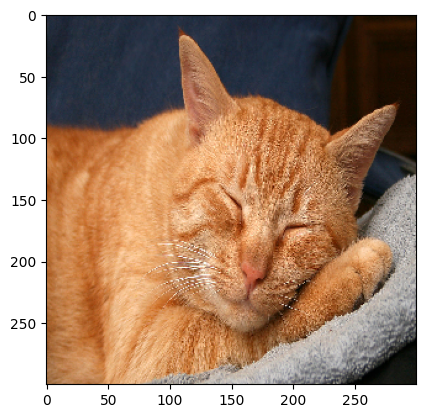

1/1 [==============================] - 0s 18ms/step

Image predicted to be cat with confidence of 61.758%
Image predicted to be chicken with confidence of 14.67%
Image predicted to be sheep with confidence of 10.617%
Image predicted to be squirrel with confidence of 6.599%
Image predicted to be elephant with confidence of 3.0%


In [45]:
img = tf.keras.preprocessing.image.load_img("G:/Python/data/img_from_google/cat1.jpg", target_size=(300, 300)) #Load image thats not already in the dataset

plt.imshow(img) #Plot image
plt.show()

img = tf.keras.preprocessing.image.img_to_array(img) #Convert image into array
img = np.expand_dims(img, axis=0) #Add dimensions to array to be processed by the model

prediction = model.predict(img) #Model predicts class of image

print()

prediction_probabilities = tf.math.top_k(prediction, k=5) #Get top-5 predictions
top_5_scores = prediction_probabilities.values.numpy().tolist() #Get top-5 probabilities
dict_class_entries = prediction_probabilities.indices.numpy().tolist() #Get matching classes to probabilities
for label, confidence in zip(dict_class_entries[0], top_5_scores[0]):
    print(f"Image predicted to be {classes[label]} with confidence of {round(confidence*100, 3)}%") #Printing the class and probability

In [12]:
model.save(os.path.join("C:/Users/maxis/Desktop/Proseminar - CNN/Models","animals_10_69_val_accuracy.h5")) #Save the structure (weights etc.) of the model